In [1]:
import pickle
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
cifar_folder = 'data/cifar-10-batches-py'

labels_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 
    'frog', 'horse', 'ship', 'truck']
label_count = len(labels_names)
print(labels_names)

def load_cifar_batch(folder, file):
    with open(os.path.join(folder, file), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    print(dict[b'batch_label'])
    return dict[b'data'], np.array(dict[b'labels'])

def load_cifar(folder):
    x_tr = list()
    y_tr = list()
    for i in range(1, 6):
        x, y = load_cifar_batch(folder, 'data_batch_' + str(i))
        x_tr.append(x)
        y_tr.append(y)
    x_tr = np.concatenate(x_tr)
    y_tr = np.concatenate(y_tr)
    x_te, y_te = load_cifar_batch(folder, 'test_batch')
    return x_tr, y_tr, x_te, y_te

x_tr, y_tr, x_te, y_te = load_cifar(cifar_folder)
print(x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
b'training batch 1 of 5'
b'training batch 2 of 5'
b'training batch 3 of 5'
b'training batch 4 of 5'
b'training batch 5 of 5'
b'testing batch 1 of 1'
(50000, 3072) (50000,) (10000, 3072) (10000,)


In [3]:
def plot_image(x, y):
    plt.imshow(x.reshape(3, 32, 32).transpose(1, 2, 0) / 256)
    plt.title(labels_names[y])
    plt.axis('off')

def show_image(x, y):
    plot_image(x, y)
    plt.show()

def show_images(xs, ys):
    n = len(xs)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plot_image(xs[i], ys[i])
    plt.show()

def show_train_images(pos):
    show_images(x_tr[pos:pos+5], y_tr[pos:pos+5])

silence = interact(show_train_images, 
        pos=widgets.BoundedIntText(min=0, max=49999, step=5, value=0, description='Range start:'))

A Jupyter Widget

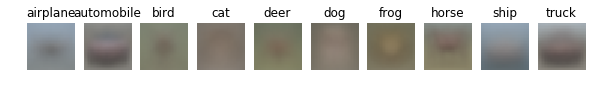

In [4]:
y_mean = range(10)
x_mean = [x_tr[y_tr == y].mean(axis=0) for y in y_mean]
show_images(x_mean, y_mean)

In [5]:
# Perform one hot encoding
y_tr_n = np.eye(label_count)[y_tr]
y_te_n = np.eye(label_count)[y_te]

print(y_tr_n.shape)
print(y_te_n.shape)

x_tr_n = x_tr / 256 - 0.5
x_te_n = x_te / 256 - 0.5

(50000, 10)
(10000, 10)


In [48]:
np.random.seed(5)
W = np.random.rand(x_tr_n.shape[1], label_count) * 0.001
B = np.random.rand(label_count) * 0.001

print(W.shape)
print(B.shape)

(3072, 10)
(10,)


In [49]:
speed = 0.1

def calculate_soft_max(x):
    x_exp = np.exp(x)
    return x_exp / np.sum(x_exp, axis=1).reshape(-1, 1)

def predict(x):
    global W
    global B
    W_in = x
    W_out = np.dot(W_in, W)
    B_in = W_out
    B_out = B_in + B
    y_pred = B_out
    return y_pred

def calculate_accuracy(y_pred, y):
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))

def calculate_loss(y_pred, y):
    print("y_pred[0]", y_pred[0])
    y_exp = np.exp(y_pred)
    print("y_exp[0]", y_exp[0])
    sm = y_exp / np.sum(y_exp, axis=1).reshape(-1, 1)
    print("sm[0]", sm[0])
    result = np.sum(sm * y, axis=1)
    print("result", result)
    result = -np.mean(np.log(np.maximum(result, 0.0001)))
    print("result", result)
    return result

def calculate_grad(y_pred, y):
    return y_pred - y

def perform_step():
    global x_tr_n
    global y_tr_n
    global W
    global B
    W_in = x_tr_n
    W_out = np.dot(W_in, W)
    B_in = W_out
    B_out = B_in + B
    y_pred = B_out
    
    print('  current loss:', calculate_loss(y_pred, y_tr_n))

    grad = calculate_grad(y_pred, y_tr_n)
    
    B = B - speed * np.sum(grad, axis=0)
    W = W - speed * np.dot(W_in.transpose(), grad)
    #W_dif_1 = W - np.roll(W, 1, axis=0)
    #W_dif_2 = W - np.roll(W, 32, axis=0)
    #W_dif_3 = W - np.roll(W, 32 * 32, axis=0)
    #W = W - speed * W_dif_1 # * np.abs(W_dif)
    #W = W - speed * W_dif_2 # * np.abs(W_dif)
    #W = W - speed * W_dif_3 # * np.abs(W_dif)
    W = W - speed * W # * np.abs(W)
    B = B - speed * B # * np.abs(B)

output = widgets.Output()
output.layout.height = '110px'
display(output)
    
loss_before = calculate_loss(predict(x_tr_n), y_tr_n)
print('Loss before:', loss_before)

speed = 0.01

for i in range(1):
    perform_step()
    if i < 10 or i % 5 == 0:
    #if i % 10 == 0:
        images = W.transpose()*5000 + 128
        images = np.minimum(255, np.maximum(0, images))
        output.clear_output()
        with(output):
            show_images(images, range(10))

loss_after = calculate_loss(predict(x_tr_n), y_tr_n)
print('Loss after:', loss_after)

print('Loss change:', loss_after - loss_before)

print('Accuracy tr:', calculate_accuracy(predict(x_tr_n), y_tr_n))
print('Accuracy te:', calculate_accuracy(predict(x_te_n), y_te_n))

A Jupyter Widget

y_pred[0] [-0.14542592 -0.14900587 -0.14290312 -0.15059157 -0.13999799 -0.14062116
 -0.14606482 -0.15039951 -0.15012349 -0.15471467]
y_exp[0] [ 0.86465394  0.86156406  0.86683805  0.86019896  0.86935998  0.86881839
  0.86410169  0.86036419  0.8606017   0.85665957]
sm[0] [ 0.10015497  0.09979706  0.10040796  0.09963894  0.10070008  0.10063735
  0.100091    0.09965808  0.09968559  0.09922896]
result [ 0.100091    0.10037818  0.10035592 ...,  0.10008494  0.09990926
  0.09984606]
result 2.30251112546
Loss before: 115125.556273
y_pred[0] [-0.14542592 -0.14900587 -0.14290312 -0.15059157 -0.13999799 -0.14062116
 -0.14606482 -0.15039951 -0.15012349 -0.15471467]
y_exp[0] [ 0.86465394  0.86156406  0.86683805  0.86019896  0.86935998  0.86881839
  0.86410169  0.86036419  0.8606017   0.85665957]
sm[0] [ 0.10015497  0.09979706  0.10040796  0.09963894  0.10070008  0.10063735
  0.100091    0.09965808  0.09968559  0.09922896]
result [ 0.100091    0.10037818  0.10035592 ...,  0.10008494  0.09990926
  0.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in maximum
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in maximum


In [20]:
speed = 0.1

def calculate_soft_max(x):
    x_exp = np.exp(x)
    return x_exp / np.sum(x_exp, axis=1).reshape(-1, 1)

def predict(x):
    global W
    global B
    W_in = x
    W_out = np.dot(W_in, W)
    B_in = W_out
    B_out = B_in + B
    SM_in = B_out
    SM_out = calculate_soft_max(SM_in)
    y_pred = SM_out
    return y_pred

def calculate_accuracy(y_pred, y):
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))

def calculate_loss(y_pred, y):
    return np.sum(-np.log(np.maximum(np.sum(y_pred * y, axis=1), 0.0001)))

def calculate_grad(y_pred, y):
    return y_pred - y

def perform_step():
    global x_tr_n
    global y_tr_n
    global W
    global B
    W_in = x_tr_n
    W_out = np.dot(W_in, W)
    B_in = W_out
    B_out = B_in + B
    y_pred = B_out
    
    print('  current loss:', calculate_loss(y_pred, y_tr_n))

    grad = calculate_grad(y_pred, y_tr_n)
    
    B = B - speed * np.sum(grad, axis=0)
    W = W - speed * np.dot(W_in.transpose(), grad)
    #W_dif_1 = W - np.roll(W, 1, axis=0)
    #W_dif_2 = W - np.roll(W, 32, axis=0)
    #W_dif_3 = W - np.roll(W, 32 * 32, axis=0)
    #W = W - speed * W_dif_1 # * np.abs(W_dif)
    #W = W - speed * W_dif_2 # * np.abs(W_dif)
    #W = W - speed * W_dif_3 # * np.abs(W_dif)
    W = W - speed * W # * np.abs(W)
    B = B - speed * B # * np.abs(B)


[[   2.71828183    7.3890561    20.08553692]
 [  54.59815003  148.4131591   403.42879349]]
[[ 0.09003057  0.24472847  0.66524096]
 [ 0.09003057  0.24472847  0.66524096]]


In [17]:
x = np.array([[1, 2, 3], [4, 5, 6]])
x_sum = np.sum(x, axis=1).reshape(-1, 1)
x / x_sum

array([[ 0.16666667,  0.33333333,  0.5       ],
       [ 0.26666667,  0.33333333,  0.4       ]])

In [11]:
images = W.transpose()*5000 + 128
images = np.minimum(255, np.maximum(0, images))

def show_image_w(index):
    show_image(images[index], index)

interact(show_image_w, index=widgets.BoundedIntText(min=0, max=9, step=1, value=0))

A Jupyter Widget

<function __main__.show_image_w>

In [12]:
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
g = np.array([[0, 10], [100, 0], [1000, 0]])
x.transpose()
#np.dot(x.transpose(), g)
#np.dot(x.reshape(-1, 1), g.reshape(1, -1))
#g = np.array([[0, 0, 1, 0], [0, -1, 0, 0]])
#np.dot(x.reshape(-1, 1), g.reshape(1, -1))

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])

In [13]:
x_tmp1 = np.array([0, 1, 2])
x_tmp = np.array([[0, 1, 2], [10, 20, 30]])
w_tmp = np.array([[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]])
print(x_tmp1)
print(x_tmp)
print(w_tmp)
print(np.dot(x_tmp, w_tmp))


[0 1 2]
[[ 0  1  2]
 [10 20 30]]
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[ 20  23  26  29]
 [320 380 440 500]]
